# 자전거 대여 수요 예측

https://www.kaggle.com/c/bike-sharing-demand/data

해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재돼있다.

* datatime : hourly date + timestamp
* seasom : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
* holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
* workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather : 
    * 1 = 맑음, 약간 구름 낀 흐림
    * 2 = 안개, 안개 + 흐림
    * 3 = 가벼운 눈, 가벼운 비 + 천둥
    * 4 = 심한 눈/비, 천둥/번개
* temp : 온도(섭씨)
* atemp : 체감온도(섭씨)
* humidity : 상대습도
* windspeed : 풍속
* casual : 사전에 등록되지 않은 사용자가 대여한 횟수
* registered : 사전에 등록된 사용자가 대어한 횟수
* count : 대여 횟수

### 데이터 클렌징 및 가공


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv("./bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


null 데이터는 없으며, 대부분 int 또는 float인데 datetime만 object형이다. datetime의 경우 년-월-일 시:분:초 문자 형식으로 되어있어 이를 가공해야한다.

datetime을 분리하여 숫자형으로 만든다.

In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x:x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x:x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x:x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


이제 datetime 칼럼은 필요하지 않아 삭제한다. 그리고 casual 칼럼은 사전에 등록하지 않은 사용자의 대여 횟수이고, registered는 사전에 등록한 사용자 대여 횟수인데, casual+registered=count이므로 casual과 registered는 따로 필요하지 않아 삭제하는 것이 좋다.

In [4]:
bike_df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

### 성능 측정

캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)이다. 즉, 오류값의 로그에 대한 RMSE이다. 사이킷런에는 RMSLE를 제공하지 않아 직접 만들어야한다.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}".format(rmsle_val, rmse_val, mae_val))

    def rmsle(y, pred):
        msle = mean_squared_log_error(y, pred)
        rmsle = np.sqrt(mse)
        return rmsle

위와 같이 mean_squared_log_error()나 log() 함수를 이용하여 rmsle를 구하게 되면 데이터 값의 크기에 따라 오버플로/언더플로(overflow/underflow) 오류가 발생하기 쉽다.

따라서 log()보다는 log1p()를 이용하는데, log1p()의 경우 1+log() 값으로 log 변환 값에 1을 더해 이러한 문제를 해결해준다. 그리고 log1p()로 변환된 값은 다시 넘파이의 expm1() 함수로 쉽게 원래 스케일로 복원될 수 있다.

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

결과값이 정규 분포로 돼있는지 확인해야하며, 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩 해야한다.

In [6]:
# 사이킷런의 LinearRegression 객체를 이용해 회귀 예측
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


RMSLE : 1.165, RMSE : 140.900, MAE : 105.924는 실제 Target 데이터 값인 대여 횟수(Count)를 감안하면 예측 오류로서는 비교적 큰 값이다. 실제값과 예측값이 어느 정도로 차이가 나는지 DataFrame의 칼럼으로 만들어 오류값이 가장 큰 순으로 5개를 확인

In [7]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값이 가장 큰 데이터순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


가장 큰 상위 5위 오류값은 546 ~ 568로 실제 값을 감안하면 예측 오류가 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인해야한다. Target 값의 분포는 정규 분포 형태가 가장 좋다. 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다.

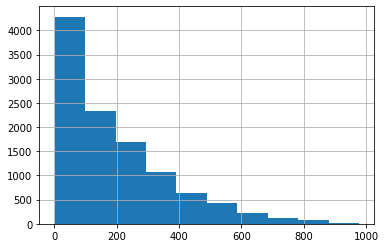

In [8]:
y_target.hist()

0~200 사이의 count 칼럼 값이 정규 분포가 아닌 왜곡되어 있는 것을 알 수 있다.

왜곡된 값을 정규 분포 형태로 바꾸는 방법 = log 적용

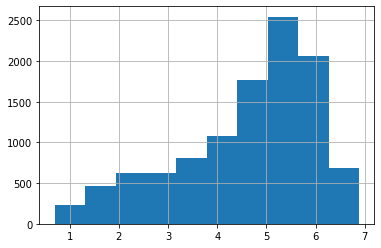

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

로그로 Target 값을 변환한 후에는 원하는 정규 분포는 아니지만 왜곡 정도가 이전보다 많이 향상되었다. 다시 학습을 수행한다.

In [10]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


로그 변환 전 -> RMSLE : 1.165, RMSE : 140.900, MAE : 105.924

로그 변환 후 -> RMSLE : 1.017, RMSE : 162.594, MAE : 109.286

RMSLE는 줄었지만, RMSE는 오히려 더 늘어났다.

각 피처의 회귀 계수값을 시각화해보자.

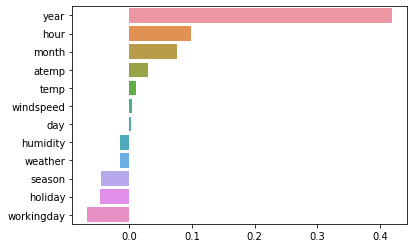

In [11]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [12]:
bike_df['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

year 피처의 회귀 계수값이 독보적으로 큰 값을 가지고 있다. year는 2011년, 2012년 두 개의 값으로 돼 있다. year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 말이 되지 않는다. year 피처는 연도를 뜻하므로 카테고리(Category)형 피처지만, 숫자형 값으로 되어있다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자형으로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야한다.

판다스의 get_dummies()를 이용해 year, month, day, hour, holiday, workingday, season, weather 칼럼을 모두 원-핫 인코딩한 후 다시 예측 성능을 확인한다.

In [13]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday', 'workingday','season','weather'])

In [14]:
# 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능확인
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다.

원-핫 인코딩된 데이터 세트에서의 회귀 계수가 높은 피처를 다시 시각화해보자. 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 25개 피처를 추출.

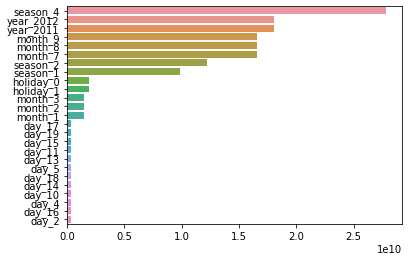

In [15]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:25]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

이번에는 회귀 트리를 이용해 회귀 예측을 수행한다. target값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해본다.

XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있어 DataFrame의 values 속성을 이용해 넘파이 ndarray로 변환한다.

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500, objective='reg:squarederror')
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.276, MAE : 31.121
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.335, MAE : 32.748
### XGBRegressor ###
RMSLE : 0.345, RMSE : 58.245, MAE : 35.768
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029
